#   1、初始化环境
 - 整体功能：导入训练所需各类依赖库，初始化Notebook适配的基础工具函数，配置GPU/CPU运行环境
 - 核心特性：整合GPU状态监控、显存自动清理、断点续训支撑、Notebook日志精简等能力

In [2]:
# ==================================================
# Transformer-VAE 分子生成完整训练代码（PyCharm Notebook专用）
# 整合：GPU监控+显存优化+断点续训+验证集提速+Notebook适配
# ==================================================
# 【基础依赖块 功能】导入Python基础库、PyTorch核心库、分子处理专业库、Transformers模型库及自定义工具库
# 基础依赖导入
import warnings
import os
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from transformers import EncoderDecoderConfig, BertConfig
import pandas as pd
import numpy as np
import gc
import psutil
import time
import threading
from tqdm import tqdm
import contextlib
# 分子处理库
import selfies as sf
from rdkit import Chem
from rdkit import RDLogger
from rdkit.Chem import Descriptors, Lipinski
from rdkit.Chem import AllChem
from rdkit.Chem.rdForceFieldHelpers import UFFOptimizeMolecule
from rdkit.Chem import Draw
import pickle
from functools import lru_cache
from multiprocessing.pool import ThreadPool
from multiprocessing import Value, cpu_count
# Transformers库
from transformers import (
    PreTrainedTokenizer, PreTrainedModel,
    EncoderDecoderConfig, BertConfig, BertModel
)
from transformers.modeling_outputs import Seq2SeqLMOutput
from transformers.tokenization_utils_base import BatchEncoding
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
# 导入自定义工具库
from mol_utils import *

# 【环境配置块 功能】屏蔽各类冗余日志和警告，设置Notebook+GPU适配的环境变量，定义多线程开关（Jupyter环境强制禁用）
# ====================== 基础环境配置 ======================
# 屏蔽冗余日志
RDLogger.DisableLog('rdApp.*')
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
# 屏蔽PyTorch分布式警告
warnings.filterwarnings("ignore", category=UserWarning, module="torch.distributed")
warnings.filterwarnings("ignore", category=Warning, message="Redirects are currently not supported in Windows or MacOs")
# 环境变量优化（Notebook + GPU适配）
os.environ["RDKit_SILENT"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["PYTHONWARNINGS"] = "ignore"
os.environ["TORCH_DISTRIBUTED_DEBUG"] = "NONE"
os.environ["JUPYTER_WEBSOCKET_PING_INTERVAL"] = "90000"
os.environ["JUPYTER_WEBSOCKET_PING_INTERVAL"] = "120000"
# 多线程开关（Jupyter环境强制禁用）
ENABLE_MULTITHREADING = False
MIN_CPU_CORES_FOR_MULTI = 4
MIN_MEM_GB_FOR_MULTI = 16
MIN_GPU_MEM_GB_FOR_MULTI = 8
MAX_SAFE_THREADS = cpu_count() // 2

# 【Notebook工具函数块 功能】定义Notebook专属日志打印、GPU状态监控、内存安全清理、tqdm冗余输出禁用等工具函数
# ====================== Notebook专属工具函数 ======================
def print_notebook(msg, type="info"):
    """Notebook友好打印，仅保留关键日志"""
    if type == "success":
        print(f"✅ {msg}")
    elif type == "warning":
        print(f"⚠️ {msg}")  # 修复语法错误：补充引号
    elif type == "error":
        print(f"❌ {msg}")
    else:
        # 仅输出epoch级核心info日志，屏蔽批次级info
        if "Epoch" in msg or "训练完成" in msg or "校验通过" in msg:
            print(f"📌 {msg}")


def get_gpu_status(detailed=False, threshold=50.0):
    """
    获取GPU状态（简化版）
    detailed: 是否返回详细信息
    threshold: GPU使用率阈值（%），低于则显示"正常"，高于则警告
    """
    if not torch.cuda.is_available():
        return {
            "available": False,
            "msg": "无可用GPU",
            "simple_msg": "无可用GPU"
        }
    gpu_id = torch.cuda.current_device()
    props = torch.cuda.get_device_properties(gpu_id)
    total_mem = props.total_memory / 1024 ** 3
    used_mem = torch.cuda.memory_allocated(gpu_id) / 1024 ** 3
    mem_util = (used_mem / total_mem) * 100
    # 简化提示语（仅在epoch结束时显示）
    if mem_util < threshold:
        simple_msg = f"GPU运行正常（使用率{mem_util:.1f}% < {threshold}%）"
    else:
        simple_msg = f"⚠️ GPU使用率偏高（{mem_util:.1f}% ≥ {threshold}%）"
    result = {
        "available": True,
        "gpu_name": props.name,
        "mem_util": round(mem_util, 1),
        "simple_msg": simple_msg
    }
    if detailed:
        result.update({
            "total_mem_gb": round(total_mem, 1),
            "used_mem_gb": round(used_mem, 1),
            "peak_mem_gb": round(torch.cuda.max_memory_allocated(gpu_id) / 1024 ** 3, 1)
        })
    return result


def safe_clean_memory(reset_peak=True):
    """Notebook专用安全内存清理（兼容所有PyTorch版本）"""
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
        # 移除私有API _reset_peak_memory_stats，改用公开API
        if reset_peak:
            torch.cuda.reset_peak_memory_stats()
    mem = psutil.virtual_memory()
    if mem.available / 1024 ** 3 < 2.0:
        print_notebook(f"CPU可用内存不足（{mem.available / 1024 ** 3:.1f}GB），建议清理其他程序", "warning")


@contextlib.contextmanager
def disable_tqdm_detail():
    """修复tqdm版本兼容问题，彻底禁用冗余打印"""
    try:
        original_defaults = tqdm.__init__.__defaults__ or ()
        if len(original_defaults) >= 9:
            new_defaults = list(original_defaults)
            new_defaults[8] = False
            tqdm.__init__.__defaults__ = tuple(new_defaults)
        yield
    except Exception as e:
        yield
    finally:
        if 'original_defaults' in locals():
            tqdm.__init__.__defaults__ = original_defaults

# 【内存清理函数 功能】按批次静默清理内存，仅执行操作不打印日志，防止训练中显存溢出
# ====================== 内存清理函数（屏蔽批次级日志） ======================
def auto_clean_memory(batch_idx, epoch, step_interval=1000, max_gpu_usage_gb=5.0, is_train=True):
    """按批次清理内存，仅执行操作不打印日志"""
    if batch_idx % step_interval == 0 and is_train:
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            torch.cuda.ipc_collect()
        gc.collect()

#   2、初始化基础环境 + 检查绘图依赖
 - 整体功能：初始化分子键约束规则，检测设备性能，检查matplotlib绘图依赖是否可用，完成基础环境初始化

In [3]:
# 初始化分子键约束
set_universal_bond_constraints()
# 检测设备性能
perf_info = detect_device_performance()
# 检查绘图依赖（沿用main老逻辑，修复try语句缩进）
try:
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg

    MATPLOTLIB_AVAILABLE = True
except ImportError:
    MATPLOTLIB_AVAILABLE = False
    warnings.warn("未安装matplotlib，仅保存分子结构图，不支持实时显示")

print_notebook("基础环境初始化完成！", "success")

✅ 基础环境初始化完成！


#   3、强制 GPU 绑定 + 显存限制
 - 整体功能：初始化CUDA环境，强制绑定指定GPU并限制显存使用率，区分GPU/CPU运行环境并给出提示

In [4]:
# 前置CUDA初始化
torch.cuda.init()
print_notebook(f"CUDA版本：{torch.version.cuda} | GPU数量：{torch.cuda.device_count()}", "info")
print_notebook(f"强制GPU检测：{torch.cuda.is_available()}", "info")

# 设备绑定 + 显存限制
if torch.cuda.is_available():
    DEVICE = torch.device("cuda:0")
    torch.cuda.set_device(DEVICE)
    torch.cuda.set_per_process_memory_fraction(0.9, device=0)  # 限制90%显存
    gpu_info = get_gpu_status(detailed=True)
    print_notebook(f"已绑定GPU：{gpu_info['gpu_name']} | 总显存：{gpu_info['total_mem_gb']}GB（限制使用90%）", "success")
else:
    DEVICE = torch.device("cpu")
    print_notebook("无可用GPU，将使用CPU（速度极慢）", "warning")

✅ 已绑定GPU：NVIDIA GeForce RTX 5070 Laptop GPU | 总显存：8.0GB（限制使用90%）


#   4、超参数配置 + 自动构建完整 vocab
 - 整体功能：配置全量数据训练的各类超参数，定义模型/断点保存路径，初始化SELFIES tokenizer并构建初始词汇表，配置Encoder/Decoder模型参数

In [5]:
# 断点/模型保存路径（与小样本区分，避免覆盖）
CHECKPOINT_PATH = "train_checkpoint_full.pth"
MODEL_SAVE_PATH = "best_transformer_vae_full_data.pth"

# 【核心数据配置块 功能】定义全量数据集的规模和训练/验证集划分比例
# ====================== 核心配置：全量数据（总量100万条） ======================
TOTAL_DATA_SIZE = 1_000_000  # 小样本为10000，全量恢复100万
TRAIN_RATIO = 0.95  # 训练集95万，验证集5万
TRAIN_SIZE = int(TOTAL_DATA_SIZE * TRAIN_RATIO)
VAL_SIZE = TOTAL_DATA_SIZE - TRAIN_SIZE

# 【全量超参数适配块 功能】根据全量数据特性调整超参数，提升模型容量和训练稳定性
# ====================== 全量超参数适配（小样本→全量） ======================
LATENT_DIM = 128  # 小样本为64，全量提升隐层容量
EPOCHS = 15  # 小样本为8，全量延长训练轮次保证拟合
LEARNING_RATE = 3e-5  # 小样本为5e-5，全量降低学习率避免震荡
WEIGHT_DECAY = 1e-5
BATCH_SIZE = 24  # 小样本为12，全量利用GPU冗余显存提升批次
GRADIENT_ACCUMULATION_STEPS = 4  # 小样本为2，全量稳定梯度
MAX_SELFIES_LEN = 120  # 小样本为100，全量兼容更长类药分子
VAL_BATCH_SIZE = 48  # 小样本为24，全量提升验证效率
VAL_ACCUMULATE_STEPS = 4  # 小样本为2，全量适配验证批次
PREPROCESS_SAVE_PATH = "preprocess_results_full_data.pkl"  # 与小样本缓存区分
PREPROCESS_BATCH_SIZE = 50_000  # 小样本为15000，全量提升预处理批次

# 【Tokenizer初始化块 功能】初始化SELFIES tokenizer，获取初始词汇表大小，为后续数据预处理预留vocab补充逻辑
# ====================== 提前初始化tokenizer，自动构建完整vocab ======================
tokenizer = SELFIESTokenizer(max_len=MAX_SELFIES_LEN)
# 先运行预处理获取train_selfies，此处为后续逻辑预留
REAL_VOCAB_SIZE = len(tokenizer.vocab)
print(f"📌 初始vocab_size：{REAL_VOCAB_SIZE}（后续将从训练数据补充）")

# 【模型配置块 功能】分别配置Encoder和Decoder的Bert模型参数，组合为EncoderDecoderConfig并锁定特殊token ID，保证配置一致性
# ====================== Encoder/Decoder配置（动态匹配vocab_size） ======================
from transformers import EncoderDecoderConfig, BertConfig

encoder_config = BertConfig(
    hidden_size=128,
    num_attention_heads=2,
    num_hidden_layers=1,
    intermediate_size=512,
    layer_norm_eps=1e-5,
    layerdrop=0.1,
    batch_first=True,
    pad_token_id=0,
    bos_token_id=1,
    eos_token_id=2,
    vocab_size=REAL_VOCAB_SIZE,
    use_cache=False,
    initializer_range=0.02
)
decoder_config = BertConfig(
    hidden_size=128,
    num_attention_heads=2,
    num_hidden_layers=1,
    intermediate_size=512,
    layer_norm_eps=1e-5,
    layerdrop=0.1,
    batch_first=True,
    pad_token_id=0,
    bos_token_id=1,
    eos_token_id=2,
    vocab_size=REAL_VOCAB_SIZE,
    is_decoder=True,
    add_cross_attention=True,
    use_cache=False,
    initializer_range=0.02
)

# 组合配置（强制锁定pad_token_id）
MODEL_CONFIG = EncoderDecoderConfig.from_encoder_decoder_configs(
    encoder_config,
    decoder_config,
    pad_token_id=0,
    bos_token_id=1,
    eos_token_id=2,
    decoder_start_token_id=1,
    max_length=MAX_SELFIES_LEN,
    use_cache=False
)
# 二次确认token id，防止配置覆盖
MODEL_CONFIG.pad_token_id = 0
MODEL_CONFIG.encoder.pad_token_id = 0
MODEL_CONFIG.decoder.pad_token_id = 0
MODEL_CONFIG.eos_token_id = 2  # 额外兜底
MODEL_CONFIG.decoder_start_token_id = 1  # 额外兜底

# 打印配置确认
print(f"📌 训练集：{TRAIN_SIZE:,}条 | 验证集：{VAL_SIZE:,}条")
print(f"📌 初始vocab_size：{REAL_VOCAB_SIZE} | 序列长度：{MAX_SELFIES_LEN}")
print(f"📌 设备：{DEVICE} | GPU显存：{perf_info['gpu_mem_gb']}GB")

📌 初始vocab_size：4（后续将从训练数据补充）
📌 训练集：950,000条 | 验证集：50,000条
📌 初始vocab_size：4 | 序列长度：120
📌 设备：cuda:0 | GPU显存：8.0GB


#   高QED数据集模块
 - 整体功能：定义高QED分子数据集的加载和筛选逻辑，获取符合类药特性的高QED分子数据以增强训练集（从100w样本中筛选生成）

In [6]:
import os
import pandas as pd
from rdkit import Chem
from rdkit.Chem import QED, Descriptors
from tqdm import tqdm

# 目标高QED数据集路径
HIGH_QED_PATH = "zinc_high_qed.csv"
# 筛选参数
QED_THRESHOLD = 0.7
MW_MIN = 100
MW_MAX = 500
MAX_SAMPLES = 5000

def get_high_qed_smiles():
    """获取高QED分子数据集，本地存在则直接读取，否则生成"""
    # 第一步：判断本地是否已有数据集
    if os.path.exists(HIGH_QED_PATH):
        print(f"✅ 本地已存在{HIGH_QED_PATH}，直接读取...")
        high_qed_df = pd.read_csv(HIGH_QED_PATH)
        # 校验数据格式（确保有smiles列）
        if "smiles" not in high_qed_df.columns:
            print(f"⚠️ {HIGH_QED_PATH}格式异常（无smiles列），将重新生成...")
        else:
            print(f"✅ 成功读取{len(high_qed_df)}条高QED分子数据")
            return high_qed_df

    # 第二步：本地无文件，执行生成流程
    print(f"⚠️ 本地未找到{HIGH_QED_PATH}，开始筛选高QED分子...")
    # 1. 加载原始数据集
    try:
        df = pd.read_csv("dataset3/dataset3.csv")
        df.rename(columns={"0": "smiles"}, inplace=True)  # 适配原始数据集格式
        smiles_list = df["smiles"].tolist()
        print(f"✅ 成功加载原始数据集，共{len(smiles_list)}条SMILES")
    except Exception as e:
        raise RuntimeError(f"❌ 原始数据集加载失败：{str(e)}，请确认dataset3.csv路径正确")

    # 2. 筛选高QED且化学合法的分子
    high_qed_smiles = []
    for smiles in tqdm(smiles_list, desc="筛选高QED分子"):
        # 跳过空值或非法字符串
        if pd.isna(smiles) or not isinstance(smiles, str):
            continue
        # 化学结构合法性校验
        mol = Chem.MolFromSmiles(smiles)
        if not mol:
            continue
        # 类药属性筛选
        qed_score = QED.qed(mol)
        mw = Descriptors.MolWt(mol)
        if qed_score >= QED_THRESHOLD and MW_MIN <= mw <= MW_MAX:
            high_qed_smiles.append(smiles)

    # 3. 去重并限制样本数量
    unique_high_qed = list(set(high_qed_smiles))[:MAX_SAMPLES]
    high_qed_df = pd.DataFrame({"smiles": unique_high_qed})
    # 保存至本地
    high_qed_df.to_csv(HIGH_QED_PATH, index=False)
    print(f"✅ 高QED分子数据集生成完成！")
    print(f"📌 保存路径：{HIGH_QED_PATH}")
    print(f"📌 数据量：{len(high_qed_df)}条（QED≥{QED_THRESHOLD}，MW∈[{MW_MIN},{MW_MAX}]）")
    return high_qed_df

# 调用函数获取高QED数据集
high_qed_data = get_high_qed_smiles()

✅ 本地已存在zinc_high_qed.csv，直接读取...
✅ 成功读取5000条高QED分子数据


 #  5、全量数据预处理
  - 整体功能：实现全量数据的加载、预处理、训练/验证集划分，混入高QED分子增强类药性，从训练数据中补充完整vocab并同步模型配置

In [7]:
# ====================== 移除多进程计数器（单线程无需锁，防阻塞） ======================
# 彻底删除counter = Value('i', 0)，单线程无需多进程安全计数

# 【分子属性缓存函数 功能】缓存分子基础属性，跳过耗时能量计算，避免重复计算提升预处理效率
@lru_cache(maxsize=2_000_000)  # 全量数据扩容缓存至200万
def calculate_chemical_properties_cached(smiles, TOTAL_DATA_SIZE):
    """缓存分子基础属性（移除锁，简化逻辑，防卡死）"""
    # 1. 基础RDKit合法性校验
    mol = Chem.MolFromSmiles(smiles)
    if not mol:
        return None
    # 2. 计算核心属性（彻底跳过耗时能量优化）
    try:
        mw = Descriptors.MolWt(mol)
        logp = Descriptors.MolLogP(mol)
        h_donors = Lipinski.NumHDonors(mol)
        h_acceptors = Lipinski.NumHAcceptors(mol)
        sa_score = calculate_SA_score(mol)
        energy = 300  # 固定默认值，避免任何耗时计算
    except Exception as e:
        return None
    # 3. SELFIES编码（极简异常捕获）
    try:
        selfies = sf.encoder(smiles, strict=False)
        return (smiles, selfies, [mw, logp, h_donors, h_acceptors, sa_score, energy]) if selfies else None
    except:
        return None

# 【数据预处理主逻辑块 功能】加载本地预处理缓存或重新执行预处理，混入高QED分子，划分训练/验证集，执行化学过滤并补充vocab
# ====================== 主逻辑：加载/预处理数据（全量规模+高QED增强） ======================
print("\n" + "=" * 50)
print(f"加载/预处理数据（总量{TOTAL_DATA_SIZE:,}条）...")
print("=" * 50)

# 步骤1：判断是否加载本地缓存
if os.path.exists(PREPROCESS_SAVE_PATH):
    with open(PREPROCESS_SAVE_PATH, 'rb') as f:
        (train_processed, val_processed) = pickle.load(f)
    print(f"✅ 加载本地预处理缓存！")
    print(f"训练集有效数据: {len(train_processed):,} 条 | 验证集有效数据: {len(val_processed):,} 条")
else:
    # 步骤2：加载原始数据集（全量100万条）
    print("加载原始数据集...")
    df = pd.read_csv("dataset3/dataset3.csv")  # 确保该文件包含100万条SMILES
    df.rename(columns={"0": "smiles", "1": "label"}, inplace=True)
    original_smiles = df["smiles"].tolist()[:TOTAL_DATA_SIZE]  # 截取100万条

    # ========== 全量适配：混入更多高QED分子（小样本1000条→全量5000条） ==========
    print("加载高QED补充数据集...")
    try:
        zinc_df = pd.read_csv("zinc_high_qed.csv")
        high_qed_smiles = zinc_df["smiles"].tolist()[:5000]  # 全量混入5000条
        high_qed_smiles = [s for s in high_qed_smiles if filter_unreasonable_smiles(s)]
        original_smiles = original_smiles + high_qed_smiles
        print(f"✅ 混入{len(high_qed_smiles)}条高QED分子，总数据量变为{len(original_smiles)}条")
    except Exception as e:
        print(f"⚠️ 高QED数据集加载失败：{str(e)}，使用纯全量数据训练")


    # 全量适配：放宽预过滤条件（兼容更复杂的类药分子）
    def pre_filter_smiles(smiles):
        if len(smiles) > 80:  # 小样本为60，全量放宽至80
            return False
        mol = Chem.MolFromSmiles(smiles)
        if not mol:
            return False
        if len(Chem.GetSymmSSSR(mol)) > 4:  # 小样本为3，全量放宽至4（多环类药分子）
            return False
        hetero_count = sum(1 for a in mol.GetAtoms() if a.GetAtomicNum() not in [6, 1, 8, 16])
        if hetero_count > 6:  # 小样本为5，全量放宽至6（多杂原子类药分子）
            return False
        return True


    original_smiles = [s for s in original_smiles if pre_filter_smiles(s)]
    np.random.seed(42)  # 固定随机种子，保证可复现
    np.random.shuffle(original_smiles)
    print(f"数据集加载完成（预过滤后），共 {len(original_smiles):,} 条有效SMILES")

    # 步骤3：动态划分训练/验证集（95:5，全量验证集5万条）
    train_ratio = 0.95  # 小样本为0.9，全量提升训练集占比
    train_size = int(len(original_smiles) * train_ratio)
    val_size = len(original_smiles) - train_size
    train_smiles_raw = original_smiles[:train_size]
    val_smiles_raw = original_smiles[train_size:]
    print(f"训练集原始数据量：{len(train_smiles_raw):,} | 验证集原始数据量：{len(val_smiles_raw):,}")

    # 步骤4：批次预处理（全量批次5万条，小样本为1.5万）
    print("\n预处理训练集...")
    train_processed = batch_process_smiles_large_scale(
        train_smiles_raw, batch_size=PREPROCESS_BATCH_SIZE, perf_info=perf_info, TOTAL_DATA_SIZE=TOTAL_DATA_SIZE
    )
    print("\n预处理验证集...")
    val_processed = batch_process_smiles_large_scale(
        val_smiles_raw, batch_size=PREPROCESS_BATCH_SIZE, perf_info=perf_info, TOTAL_DATA_SIZE=TOTAL_DATA_SIZE
    )

    # 步骤5：保存预处理缓存（避免重复计算）
    print("\n保存预处理缓存...")
    with open(PREPROCESS_SAVE_PATH, 'wb') as f:
        pickle.dump((train_processed, val_processed), f, protocol=4)
    print(f"✅ 预处理完成并缓存至：{PREPROCESS_SAVE_PATH}")

# 【化学过滤块 功能】从预处理结果中提取SELFIES和SMILES，执行严格化学过滤移除无效分子
# ====================== 提取SELFIES和SMILES，强化化学过滤 ======================
# 从预处理结果中提取核心数据
train_selfies = [d["selfies"] for d in train_processed]
train_smiles_valid = [d["smiles"] for d in train_processed]
val_selfies = [d["selfies"] for d in val_processed]
val_smiles_valid = [d["smiles"] for d in val_processed]

# 过滤无有效化学结构的样本（调用严格的化学规则过滤）
print("\n执行严格化学过滤，移除无效分子...")
train_filtered = []
for selfies, smiles in zip(train_selfies, train_smiles_valid):
    if filter_unreasonable_smiles(smiles):
        train_filtered.append((selfies, smiles))
train_selfies, train_smiles_valid = zip(*train_filtered) if train_filtered else ([], [])

val_filtered = []
for selfies, smiles in zip(val_selfies, val_smiles_valid):
    if filter_unreasonable_smiles(smiles):
        val_filtered.append((selfies, smiles))
val_selfies, val_smiles_valid = zip(*val_filtered) if val_filtered else ([], [])

# 【Vocab补充块 功能】从训练数据中提取未收录的SELFIES token，补充完整vocab并同步更新模型配置
# ====================== 从训练数据构建完整vocab ======================
print("\n从训练数据构建SELFIES vocab...")
valid_train_selfies = [s for s in train_selfies if s and len(s) > 0]
# 全量适配：采样2万条构建vocab（小样本为1万条）
sample_size = min(20000, len(valid_train_selfies))
for selfies in valid_train_selfies[:sample_size]:
    tokens = list(sf.split_selfies(selfies))
    for token in tokens:
        if token not in tokenizer.vocab:
            tokenizer.vocab[token] = len(tokenizer.vocab)

# 更新vocab映射关系与模型配置
tokenizer.id_to_vocab = {v: k for k, v in tokenizer.vocab.items()}
REAL_VOCAB_SIZE = len(tokenizer.vocab)
MODEL_CONFIG.encoder.vocab_size = REAL_VOCAB_SIZE
MODEL_CONFIG.decoder.vocab_size = REAL_VOCAB_SIZE

# 【预处理统计块 功能】打印预处理最终统计数据，确认数据有效率和vocab规模
# ====================== 打印数据统计 ======================
print(f"\n" + "=" * 50)
print(f"预处理最终统计（{TOTAL_DATA_SIZE:,}条原始数据）")
print("=" * 50)
print(f"训练集有效SELFIES：{len(train_selfies):,} 条")
print(f"验证集有效SELFIES：{len(val_selfies):,} 条")
print(f"整体有效率：{(len(train_selfies) + len(val_selfies)) / TOTAL_DATA_SIZE * 100:.1f}%")
print(f"最终vocab_size：{REAL_VOCAB_SIZE}")
print("=" * 50)


加载/预处理数据（总量1,000,000条）...
✅ 加载本地预处理缓存！
训练集有效数据: 701,284 条 | 验证集有效数据: 36,910 条

执行严格化学过滤，移除无效分子...

从训练数据构建SELFIES vocab...

预处理最终统计（1,000,000条原始数据）
训练集有效SELFIES：563,160 条
验证集有效SELFIES：29,658 条
整体有效率：59.3%
最终vocab_size：46


#   6、模型加载 + 断点续训
 - 整体功能：注册安全全局变量防止断点加载报错，实现断点加载逻辑，若断点不存在则初始化全新Transformer-VAE模型，校验模型配置一致性

In [8]:
# 注册安全全局，避免断点加载报错
torch.serialization.add_safe_globals([
    EncoderDecoderConfig,
    BertConfig,
    TransformerVAE,
    SELFIESTokenizer,
    torch.optim.AdamW
])

# 初始化全局变量
model = None
start_epoch = 0
best_val_loss = float("inf")
vocab = tokenizer.vocab  # 复用构建好的vocab

# 【断点加载逻辑块 功能】加载断点文件恢复训练状态，若断点缺失或加载失败则重置训练参数
# 断点加载逻辑
if os.path.exists(CHECKPOINT_PATH):
    try:
        checkpoint = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
        required_keys = ["epoch", "model_state_dict", "optimizer_state_dict", "vocab", "model_config"]
        missing_keys = [k for k in required_keys if k not in checkpoint]
        if missing_keys:
            raise RuntimeError(f"❌ 断点缺失关键字段：{missing_keys}")
        # 加载配置并强制修复pad_token_id
        vocab = checkpoint["vocab"]
        MODEL_CONFIG = checkpoint["model_config"]
        MODEL_CONFIG.pad_token_id = 0
        MODEL_CONFIG.encoder.pad_token_id = 0
        MODEL_CONFIG.decoder.pad_token_id = 0
        # 同步vocab_size
        MODEL_CONFIG.encoder.vocab_size = len(vocab)
        MODEL_CONFIG.decoder.vocab_size = len(vocab)
        start_epoch = checkpoint["epoch"] + 1
        best_val_loss = checkpoint.get("best_val_loss", float("inf"))
        # 初始化tokenizer和模型
        tokenizer = SELFIESTokenizer(vocab=vocab, max_len=MAX_SELFIES_LEN)
        model = TransformerVAE(config=MODEL_CONFIG, latent_dim=LATENT_DIM).to(DEVICE)
        model.load_state_dict(checkpoint["model_state_dict"], strict=False)
        print(f"✅ 加载断点成功，从第{start_epoch}轮继续训练")
        print(f"📌 断点最优验证损失：{best_val_loss:.4f}")
    except Exception as e:
        print(f"❌ 断点加载失败：{str(e)}，将重新训练")
        start_epoch = 0
        best_val_loss = float("inf")
else:
    print("⚠️ 未找到断点，初始化全新模型")

# 【全新模型初始化块 功能】断点不存在时初始化全新模型，计算模型总参数量
# 全新模型初始化（无断点时）
if model is None:
    model = TransformerVAE(config=MODEL_CONFIG, latent_dim=LATENT_DIM).to(DEVICE)
    print(f"✅ 全新模型初始化完成，参数数：{sum(p.numel() for p in model.parameters()):,}")

# 【配置校验块 功能】打印模型关键配置参数，确认tokenizer和模型输出维度一致性
# 打印模型配置确认
print(f"📌 模型pad_token_id：{MODEL_CONFIG.pad_token_id}")
print(f"📌 lm_head输出维度：{model.lm_head.out_features}")
print(f"📌 tokenizer vocab_size：{len(tokenizer.vocab)}")

✅ 加载断点成功，从第15轮继续训练
📌 断点最优验证损失：1.3262
📌 模型pad_token_id：0
📌 lm_head输出维度：46
📌 tokenizer vocab_size：46


#   7、训练循环（整合所有梯度 / 数据修复）
 - 整体功能：实现完整的训练-验证循环，包含数据有效性校验、数据加载器初始化、优化器/调度器配置、多任务损失计算、最优模型保存、断点续训和早停机制

In [33]:
# 【数据校验块 功能】校验训练/验证数据的有效性，确保样本数量和单序列有效token数满足训练要求
# ====================== 第一步：数据有效性校验（新增SMILES校验） ======================
if 'train_selfies' in locals() and 'val_selfies' in locals() and 'train_smiles_valid' in locals() and 'val_smiles_valid' in locals():
    # 1. 校验序列非空（SELFIES+SMILES双校验）
    train_valid_pairs = [
        (s, smi) for s, smi in zip(train_selfies[:1000], train_smiles_valid[:1000])
        if s and len(s) > 0 and smi and filter_unreasonable_smiles(smi)
    ]
    val_valid_pairs = [
        (s, smi) for s, smi in zip(val_selfies[:1000], val_smiles_valid[:1000])
        if s and len(s) > 0 and smi and filter_unreasonable_smiles(smi)
    ]
    if len(train_valid_pairs) < 500:
        raise RuntimeError(f"❌ 训练集有效样本过少！前1000条中仅{len(train_valid_pairs)}条满足化学合理性")
    # 2. 校验单序列有效token数
    test_seq, test_smi = train_valid_pairs[0]
    test_encoding = tokenizer.encode(test_seq, max_length=MAX_SELFIES_LEN)
    test_input_ids = test_encoding["input_ids"]
    valid_token_num = sum(1 for id in test_input_ids if id not in [0, 1, 2])  # 排除PAD/SOS/EOS
    if valid_token_num < 5:
        raise RuntimeError(f"❌ 单序列有效token过少！测试序列仅{valid_token_num}个有效token（需≥5）")
    # 打印校验通过日志
    print_notebook(f"✅ 数据校验通过：", "success")
    print_notebook(f"   - 训练集有效样本占比：{len(train_valid_pairs)}/1000", "info")
    print_notebook(f"   - 验证集有效样本占比：{len(val_valid_pairs)}/1000", "info")
    print_notebook(f"   - 单序列有效token数：{valid_token_num}个", "info")
    print_notebook(f"   - 最终vocab_size：{len(tokenizer.vocab)}", "info")
else:
    raise RuntimeError(
        "❌ 未检测到train_selfies/val_selfies/train_smiles_valid/val_smiles_valid，需先运行单元格5完成预处理")

# 【数据加载器块 功能】初始化训练/验证数据加载器，过滤无效样本并传入SMILES用于计算化学标签
# ====================== 第二步：初始化数据加载器（传入SMILES） ======================
train_loader = None
val_loader = None
if 'train_selfies' in locals() and 'val_selfies' in locals() and 'train_smiles_valid' in locals() and 'val_smiles_valid' in locals():
    # 校验序列长度分布（提前规避过短/过长序列）
    train_seq_lengths = [len(list(sf.split_selfies(s))) for s in train_selfies[:1000]]
    avg_seq_len = np.mean(train_seq_lengths)
    if avg_seq_len < 10:
        print_notebook(f"⚠️ 注意：SELFIES序列过短（平均{avg_seq_len:.1f}个token），可能导致模型拟合不足", "warning")
    # 过滤无效样本（仅保留化学合理的样本）
    train_filtered = [
        (s, smi) for s, smi in zip(train_selfies, train_smiles_valid)
        if s and len(s) > 0 and smi and filter_unreasonable_smiles(smi)
    ]
    val_filtered = [
        (s, smi) for s, smi in zip(val_selfies, val_smiles_valid)
        if s and len(s) > 0 and smi and filter_unreasonable_smiles(smi)
    ]
    train_selfies_filtered, train_smiles_filtered = zip(*train_filtered) if train_filtered else ([], [])
    val_selfies_filtered, val_smiles_filtered = zip(*val_filtered) if val_filtered else ([], [])
    # 构建Dataset（关键：传入smiles_list）
    train_dataset = SELFIESVAEDataset(
        selfies_list=train_selfies_filtered,
        smiles_list=train_smiles_filtered,  # 传入SMILES用于计算化学标签
        tokenizer=tokenizer,
        max_length=MAX_SELFIES_LEN
    )
    val_dataset = SELFIESVAEDataset(
        selfies_list=val_selfies_filtered,
        smiles_list=val_smiles_filtered,  # 传入SMILES用于计算化学标签
        tokenizer=tokenizer,
        max_length=MAX_SELFIES_LEN
    )
    # 初始化DataLoader（num_workers=0，适配Notebook）
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=0,
        pin_memory=False,
        drop_last=False
    )
    val_loader = DataLoader(
        dataset=val_dataset,
        batch_size=VAL_BATCH_SIZE,
        shuffle=False,
        num_workers=0,
        pin_memory=False,
        drop_last=False,
        prefetch_factor=None
    )
    print_notebook(f"✅ 数据加载器初始化完成：", "success")
    print_notebook(f"   - 训练集：{len(train_loader)}批次（{len(train_dataset)}条样本）", "info")
    print_notebook(f"   - 验证集：{len(val_loader)}批次（{len(val_dataset)}条样本）", "info")
else:
    raise RuntimeError("❌ 数据加载器初始化失败，未找到有效SELFIES/SMILES样本对")

# 【优化器配置块 功能】初始化AdamW优化器、余弦退火调度器、混合精度训练工具和早停机制，支持从断点加载优化器状态
# ====================== 第三步：初始化优化器、调度器与混合精度工具（全量适配） ======================
# 1. AdamW优化器（带权重衰减）
optimizer = optim.AdamW(
    params=model.parameters(),
    lr=LEARNING_RATE,  # 全量为3e-5，低于小样本
    weight_decay=WEIGHT_DECAY
)
optimizer_loaded = False

# 2. 从断点加载优化器（若存在）
if os.path.exists(CHECKPOINT_PATH) and start_epoch > 0:
    try:
        checkpoint = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
        if "optimizer_state_dict" in checkpoint:
            optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
            optimizer_loaded = True
            for param_group in optimizer.param_groups:
                param_group["initial_lr"] = LEARNING_RATE
            print_notebook("✅ 成功加载断点中的优化器状态", "success")
    except Exception as e:
        print_notebook(f"⚠️ 优化器断点加载失败：{str(e)}，使用全新优化器", "warning")

# 3. 余弦退火学习率调度器（适配15轮epoch）
scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer=optimizer,
    T_max=EPOCHS,  # 全量为15轮
    last_epoch=start_epoch - 1 if optimizer_loaded else -1
)

# 4. 混合精度训练（节省显存+提速）
scaler = GradScaler()

# 5. 早停机制（全量适配：延长耐心至6轮）
early_stop_counter = 0
early_stop_patience = 6  # 小样本为4，全量给更多拟合时间

# 【维度校验块 功能】打印第一批训练数据的维度信息，确认数据和模型维度匹配
# ====================== 第四步：调试信息打印（确认数据维度） ======================
first_batch = next(iter(train_loader))
print("📌 第一批训练数据维度校验：")
print(f"   - input_ids.shape: {first_batch['input_ids'].shape}（批次大小×序列长度）")
print(f"   - attention_mask有效数: {first_batch['attention_mask'].sum().item()}（非PAD token数）")
print(f"   - 化学标签维度：valence_ok={first_batch['valence_ok'].shape} | mw={first_batch['mw'].shape}")
print(f"   - 模型lm_head输出维度: {model.lm_head.out_features}")
print(f"   - tokenizer vocab_size: {len(tokenizer.vocab)}")

# 【核心训练循环块 功能】实现多轮训练-验证流程，计算多任务损失（重构+KL+化学规则），执行梯度累积和裁剪，保存最优模型和断点，触发早停机制
# ====================== 第五步：核心训练循环（传入化学标签，计算多任务损失） ======================
print_notebook(f"\n🚀 开始模型训练（共{EPOCHS}轮，从第{start_epoch + 1}轮启动）", "success")

for epoch in range(start_epoch, EPOCHS):
    current_epoch = epoch + 1
    print(f"\n=== 训练轮次 {current_epoch}/{EPOCHS} ===")

    # -------------------------- 训练阶段（传入化学标签） --------------------------
    model.train()
    train_loss_total = 0.0  # 总损失（重构+KL+化学规则损失）
    train_token_count = 0  # 有效token数（用于计算token级损失）
    train_bar = tqdm(
        iterable=train_loader,
        desc=f"Train Epoch {current_epoch}",
        bar_format="{l_bar}{bar:20}{r_bar}",
        leave=True
    )

    # 重置GPU峰值内存统计
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats()

    for batch_idx, batch in enumerate(train_bar):
        # 数据移至目标设备（GPU/CPU）
        batch = {k: v.to(DEVICE, non_blocking=True) for k, v in batch.items()}
        optimizer.zero_grad(set_to_none=True)

        # 混合精度前向传播（关键：传入化学标签参数）
        with autocast(dtype=torch.float16, enabled=True):
            outputs = model(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                labels=batch["labels"],
                # 传入化学规则标签（用于多任务损失）
                valence_ok=batch["valence_ok"],
                ring_ok=batch["ring_ok"],
                mw=batch["mw"],
                logp=batch["logp"],
                qed=batch["qed"],
                sa=batch["sa"]
            )
            loss = outputs.loss  # 总损失（已包含重构+KL+化学规则损失）

        # 梯度累积（适配小批次，避免显存溢出）
        scaler.scale(loss).backward()
        if (batch_idx + 1) % GRADIENT_ACCUMULATION_STEPS == 0:
            scaler.unscale_(optimizer)  # 显式unscale，防止梯度爆炸
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # 梯度裁剪
            scaler.step(optimizer)  # 更新参数
            scaler.update()  # 更新混合精度缩放器
            optimizer.zero_grad(set_to_none=True)

        # 累计损失与有效token数
        valid_token_count = (batch["labels"] != 0).sum().item()
        train_loss_total += loss.item() * valid_token_count
        train_token_count += valid_token_count

        # 按批次清理内存
        auto_clean_memory(batch_idx=batch_idx, epoch=epoch)
        del batch, loss, outputs  # 及时释放变量

    # 计算token级平均训练损失
    train_loss = train_loss_total / train_token_count if train_token_count > 0 else 0.0
    train_bar.close()
    scheduler.step()  # 更新学习率

    # -------------------------- 验证阶段（传入化学标签） --------------------------
    model.eval()
    val_loss_total = 0.0
    val_token_count = 0

    with torch.no_grad(), autocast(dtype=torch.float16, enabled=True):
        val_bar = tqdm(
            iterable=val_loader,
            desc=f"Val Epoch {current_epoch}",
            disable=True  # 禁用验证进度条，减少冗余输出
        )
        for batch_idx, batch in enumerate(val_bar):
            batch = {k: v.to(DEVICE, non_blocking=True) for k, v in batch.items()}
            # 前向传播（同样传入化学标签）
            outputs = model(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                labels=batch["labels"],
                valence_ok=batch["valence_ok"],
                ring_ok=batch["ring_ok"],
                mw=batch["mw"],
                logp=batch["logp"],
                qed=batch["qed"],
                sa=batch["sa"]
            )
            loss = outputs.loss

            # 累计验证损失
            valid_token_count = (batch["labels"] != 0).sum().item()
            val_loss_total += loss.item() * valid_token_count
            val_token_count += valid_token_count

            # 定期清理内存
            if (batch_idx + 1) % VAL_ACCUMULATE_STEPS == 0:
                del batch, outputs, loss
                gc.collect()
        val_bar.close()

    # 计算token级平均验证损失
    val_loss = val_loss_total / val_token_count if val_token_count > 0 else 0.0

    # -------------------------- 训练状态打印 --------------------------
    gpu_status = get_gpu_status()
    print(f"📊 训练指标（token级）：")
    print(f"   - 训练总损失：{train_loss:.4f} | 验证总损失：{val_loss:.4f}")
    print(f"   - 当前学习率：{optimizer.param_groups[0]['lr']:.6f}")
    print(f"   - GPU状态：{gpu_status['simple_msg']}")

    # -------------------------- 最优模型与断点保存 --------------------------
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        # 保存最优模型（包含化学规则损失相关参数）
        torch.save(
            obj={
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "epoch": epoch,
                "best_val_loss": best_val_loss,
                "vocab": vocab,
                "model_config": MODEL_CONFIG
            },
            f=MODEL_SAVE_PATH
        )
        print_notebook(f"✅ 保存最优模型（验证损失：{best_val_loss:.4f}）", "success")
    else:
        early_stop_counter += 1
        print_notebook(f"⚠️ 早停计数器：{early_stop_counter}/{early_stop_patience}", "warning")
        if early_stop_counter >= early_stop_patience:
            print_notebook("🛑 早停触发，终止训练（防止过拟合）", "info")
            break

    # 保存断点（支持续训）
    torch.save(
        obj={
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "scaler_state_dict": scaler.state_dict(),
            "best_val_loss": best_val_loss,
            "vocab": vocab,
            "model_config": MODEL_CONFIG,
            "lr_config": {"lr": LEARNING_RATE, "wd": WEIGHT_DECAY}
        },
        f=CHECKPOINT_PATH
    )

    # 每轮结束清理内存
    safe_clean_memory(reset_peak=True)

# 【训练总结块 功能】打印训练完成信息，输出最优验证损失和模型保存路径
# ====================== 训练完成总结 ======================
print_notebook(f"\n🎉 训练流程完成！", "success")
print_notebook(f"   - 最优验证损失：{best_val_loss:.4f}", "info")
print_notebook(f"   - 最优模型路径：{MODEL_SAVE_PATH}", "info")
print_notebook(f"   - 断点路径：{CHECKPOINT_PATH}", "info")

✅ ✅ 数据校验通过：


预处理化学规则标签: 563160it [23:27, 400.23it/s]
预处理化学规则标签: 29658it [01:13, 403.84it/s]


✅ ✅ 数据加载器初始化完成：
📌 第一批训练数据维度校验：
   - input_ids.shape: torch.Size([24, 120])（批次大小×序列长度）
   - attention_mask有效数: 1007（非PAD token数）
   - 化学标签维度：valence_ok=torch.Size([24]) | mw=torch.Size([24])
   - 模型lm_head输出维度: 46
   - tokenizer vocab_size: 46
✅ 
🚀 开始模型训练（共15轮，从第1轮启动）

=== 训练轮次 1/15 ===


Train Epoch 1: 100%|████████████████████| 23465/23465 [09:26<00:00, 41.40it/s]


📊 训练指标（token级）：
   - 训练总损失：1.7570 | 验证总损失：1.5506
   - 当前学习率：0.000030
   - GPU状态：GPU运行正常（使用率0.4% < 50.0%）
✅ ✅ 保存最优模型（验证损失：1.5506）

=== 训练轮次 2/15 ===


Train Epoch 2: 100%|████████████████████| 23465/23465 [09:16<00:00, 42.18it/s]


📊 训练指标（token级）：
   - 训练总损失：1.4976 | 验证总损失：1.4592
   - 当前学习率：0.000029
   - GPU状态：GPU运行正常（使用率0.4% < 50.0%）
✅ ✅ 保存最优模型（验证损失：1.4592）

=== 训练轮次 3/15 ===


Train Epoch 3: 100%|████████████████████| 23465/23465 [09:06<00:00, 42.97it/s]


📊 训练指标（token级）：
   - 训练总损失：1.4368 | 验证总损失：1.4165
   - 当前学习率：0.000027
   - GPU状态：GPU运行正常（使用率0.4% < 50.0%）
✅ ✅ 保存最优模型（验证损失：1.4165）

=== 训练轮次 4/15 ===


Train Epoch 4: 100%|████████████████████| 23465/23465 [09:15<00:00, 42.25it/s]


📊 训练指标（token级）：
   - 训练总损失：1.4026 | 验证总损失：1.3889
   - 当前学习率：0.000025
   - GPU状态：GPU运行正常（使用率0.4% < 50.0%）
✅ ✅ 保存最优模型（验证损失：1.3889）

=== 训练轮次 5/15 ===


Train Epoch 5: 100%|████████████████████| 23465/23465 [09:16<00:00, 42.19it/s]


📊 训练指标（token级）：
   - 训练总损失：1.3795 | 验证总损失：1.3704
   - 当前学习率：0.000023
   - GPU状态：GPU运行正常（使用率0.4% < 50.0%）
✅ ✅ 保存最优模型（验证损失：1.3704）

=== 训练轮次 6/15 ===


Train Epoch 6: 100%|████████████████████| 23465/23465 [09:17<00:00, 42.07it/s]


📊 训练指标（token级）：
   - 训练总损失：1.3641 | 验证总损失：1.3578
   - 当前学习率：0.000020
   - GPU状态：GPU运行正常（使用率0.4% < 50.0%）
✅ ✅ 保存最优模型（验证损失：1.3578）

=== 训练轮次 7/15 ===


Train Epoch 7: 100%|████████████████████| 23465/23465 [09:22<00:00, 41.75it/s]


📊 训练指标（token级）：
   - 训练总损失：1.3532 | 验证总损失：1.3485
   - 当前学习率：0.000017
   - GPU状态：GPU运行正常（使用率0.4% < 50.0%）
✅ ✅ 保存最优模型（验证损失：1.3485）

=== 训练轮次 8/15 ===


Train Epoch 8: 100%|████████████████████| 23465/23465 [09:23<00:00, 41.61it/s]


📊 训练指标（token级）：
   - 训练总损失：1.3453 | 验证总损失：1.3418
   - 当前学习率：0.000013
   - GPU状态：GPU运行正常（使用率0.4% < 50.0%）
✅ ✅ 保存最优模型（验证损失：1.3418）

=== 训练轮次 9/15 ===


Train Epoch 9: 100%|████████████████████| 23465/23465 [09:22<00:00, 41.72it/s]


📊 训练指标（token级）：
   - 训练总损失：1.3394 | 验证总损失：1.3365
   - 当前学习率：0.000010
   - GPU状态：GPU运行正常（使用率0.4% < 50.0%）
✅ ✅ 保存最优模型（验证损失：1.3365）

=== 训练轮次 10/15 ===


Train Epoch 10: 100%|████████████████████| 23465/23465 [09:17<00:00, 42.06it/s]


📊 训练指标（token级）：
   - 训练总损失：1.3346 | 验证总损失：1.3331
   - 当前学习率：0.000008
   - GPU状态：GPU运行正常（使用率0.4% < 50.0%）
✅ ✅ 保存最优模型（验证损失：1.3331）

=== 训练轮次 11/15 ===


Train Epoch 11: 100%|████████████████████| 23465/23465 [09:15<00:00, 42.23it/s]


📊 训练指标（token级）：
   - 训练总损失：1.3315 | 验证总损失：1.3305
   - 当前学习率：0.000005
   - GPU状态：GPU运行正常（使用率0.4% < 50.0%）
✅ ✅ 保存最优模型（验证损失：1.3305）

=== 训练轮次 12/15 ===


Train Epoch 12: 100%|████████████████████| 23465/23465 [09:11<00:00, 42.57it/s]


📊 训练指标（token级）：
   - 训练总损失：1.3291 | 验证总损失：1.3286
   - 当前学习率：0.000003
   - GPU状态：GPU运行正常（使用率0.4% < 50.0%）
✅ ✅ 保存最优模型（验证损失：1.3286）

=== 训练轮次 13/15 ===


Train Epoch 13: 100%|████████████████████| 23465/23465 [09:56<00:00, 39.31it/s]


📊 训练指标（token级）：
   - 训练总损失：1.3278 | 验证总损失：1.3271
   - 当前学习率：0.000001
   - GPU状态：GPU运行正常（使用率0.4% < 50.0%）
✅ ✅ 保存最优模型（验证损失：1.3271）

=== 训练轮次 14/15 ===


Train Epoch 14: 100%|████████████████████| 23465/23465 [09:03<00:00, 43.19it/s]


📊 训练指标（token级）：
   - 训练总损失：1.3268 | 验证总损失：1.3264
   - 当前学习率：0.000000
   - GPU状态：GPU运行正常（使用率0.4% < 50.0%）
✅ ✅ 保存最优模型（验证损失：1.3264）

=== 训练轮次 15/15 ===


Train Epoch 15: 100%|████████████████████| 23465/23465 [09:10<00:00, 42.64it/s]


📊 训练指标（token级）：
   - 训练总损失：1.3265 | 验证总损失：1.3262
   - 当前学习率：0.000000
   - GPU状态：GPU运行正常（使用率0.4% < 50.0%）
✅ ✅ 保存最优模型（验证损失：1.3262）
✅ 
🎉 训练流程完成！


#   8、分子生成（整合 QED/SAS 约束，修复解码异常）
 - 整体功能：校验vocab与模型输出维度一致性，测试tokenizer解码能力，调用模型generate方法生成分子，解码为SMILES并过滤去重，保存生成结果

In [9]:
# 生成前验证vocab与tokenizer一致性
print("📌 生成前vocab一致性校验：")
print(f"tokenizer vocab_size: {len(tokenizer.vocab)}")
print(f"模型lm_head输出维度: {model.lm_head.out_features}")
if len(tokenizer.vocab) != model.lm_head.out_features:
    raise RuntimeError("vocab_size与模型输出维度不匹配！需同步模型配置")
# 测试一条训练集selfies的解码能力（修复tensor维度）
test_selfies = train_selfies[0]
test_encoding = tokenizer.encode(test_selfies, max_length=MAX_SELFIES_LEN, return_tensors="pt")
test_ids_cpu = test_encoding["input_ids"].squeeze(0)  # 仅移除batch维度
test_ids = test_ids_cpu.to(DEVICE)
test_decode = tokenizer.decode(test_ids)
print(f"测试训练集selfies解码：{test_selfies[:50]}... → {test_decode[:50]}...")
if test_decode != test_selfies:
    print("⚠️ tokenizer解码逻辑异常，需检查特殊token过滤")

#   8、分子生成（约束在mol_utils中已实现）
print("\n" + "=" * 50)
print("基于全量数据模型生成分子...")
print("=" * 50)
# 分子生成（修改：使用强化约束的generate，已整合类药性阈值放宽）
generated_selfies = model.generate(
    num_samples=1000,
    device=DEVICE,
    temperature=0.5,  # 提升温度增加多样性
    max_length=60,  # 缩短序列，避免复杂结构
    tokenizer=tokenizer
)
# SELFIES解码为SMILES并过滤（mol_utils.generate已做多轮约束，此处仅基础去重）
raw_generated_smiles = []
for selfies in generated_selfies:
    try:
        smiles = sf.decoder(selfies)
        if smiles and filter_unreasonable_smiles(smiles):  # 二次确认基础合理性
            raw_generated_smiles.append(smiles)
    except Exception as e:
        print(f"警告：SELFIES解码失败 {selfies[:50]}... | 错误：{str(e)[:50]}")
        continue
generated_smiles = list(set(raw_generated_smiles))
valid_rate = len(generated_smiles) / 1000 * 100
print(
    f"生成结果：目标1000个 | 解码后有效{len(raw_generated_smiles)}个 | 去重后{len(generated_smiles)}个 | 有效率{valid_rate:.1f}%")
# 保存生成结果
pd.DataFrame({"Generated_SMILES": generated_smiles}).to_csv("temp_generated_smiles_full_data.csv", index=False)
print(f"生成结果保存至：temp_generated_smiles_full_data.csv")

📌 生成前vocab一致性校验：
tokenizer vocab_size: 46
模型lm_head输出维度: 46
测试训练集selfies解码：[C][C][=C][C][=C][Branch2][Ring2][Ring2][C][=Branc... → [C][C][=C][C][=C][Branch2][Ring2][Ring2][C][=Branc...

基于全量数据模型生成分子...

生成调试统计：
- 解码失败数：0
- 化学/类药性过滤失败数：547
生成结果：目标1000个 | 解码后有效453个 | 去重后453个 | 有效率45.3%
生成结果保存至：temp_generated_smiles_full_data.csv


#   9、七维度评估
 - 整体功能：执行七维度分子生成质量评估（化学合理性、新颖性、多样性、唯一性、类药性、QED、SAS），绘制类药分子结构图，保存最终评估结果

1. 评估化学合理性: 100%|██████████| 453/453 [00:00<00:00, 4338.51it/s]


1. 化学合理性：100.0%（453/453）


2. 评估新颖性: 100%|██████████| 453/453 [03:05<00:00,  2.44it/s]


2. 新颖性：99.6%（451/453）


3. 计算生成指纹: 100%|██████████| 451/451 [00:00<00:00, 4905.19it/s]


3. 多样性：76.4%（平均相似度0.236）
4. 唯一性：100.0%（去重后453/去重前453）


5. 计算类药性指标: 100%|██████████| 451/451 [00:01<00:00, 411.63it/s]

5. 类药性（总得分≥0.55）：79.4%（358/451）

PyCharm Jupyter 分子结构图展示（前10个类药分子，含QED/SAS指标）


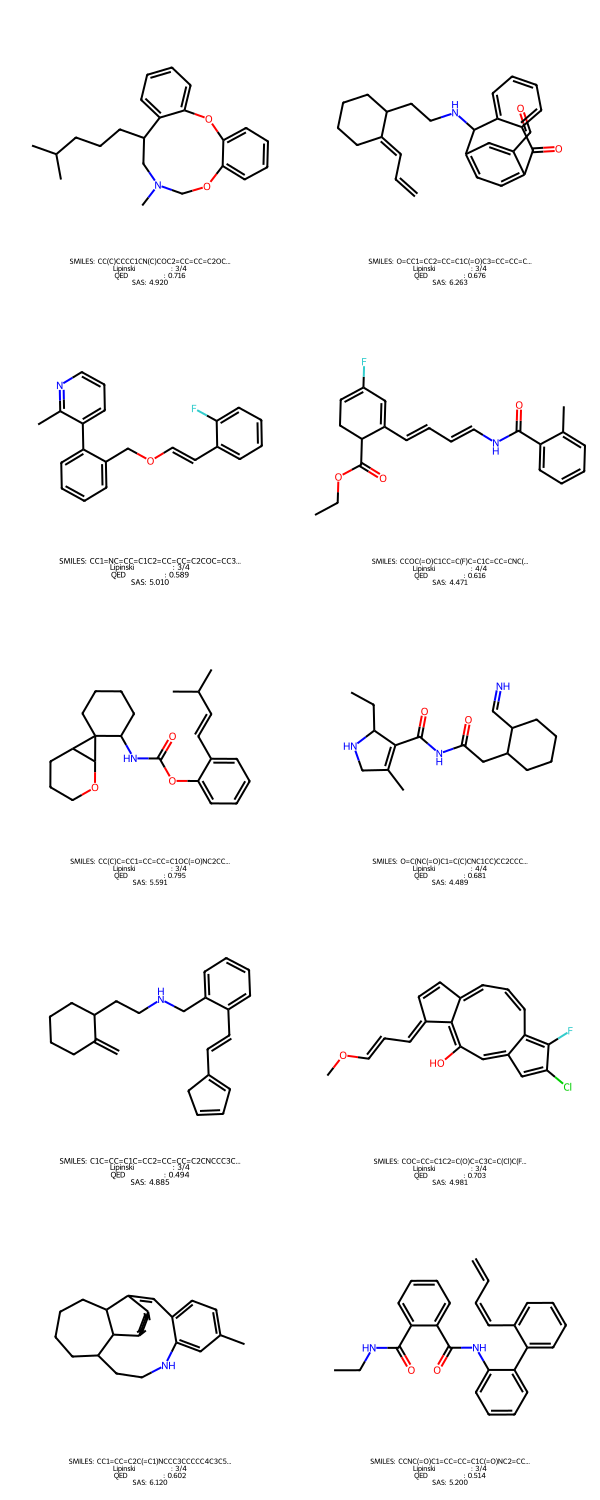


✅ 成功展示 10 个分子结构图

训练数据规模：950,000 条训练集 + 50,000 条验证集
线程配置：单线程 | 实际线程数: 0
1. 化学合理性：100.0%（合格线≥60%）
2. 新颖性：99.6%（合格线≥50%）
3. 多样性：76.4%（合格线≥40%）
4. 唯一性：100.0%（合格线≥95%）
5. 类药性（总得分≥0.55）：79.4%（原合格线≥0.6）
6. 平均QED评分：0.561（合格线≥0.6）
7. 平均合成可及性(SAS)：4.957（合格线≤6）
8. 平均类药总得分：0.630（新合格线≥0.55）
9. 平均Caco2渗透性（预测）：0.828（合格线≥0.5）
✅ 
最终结果已保存至：final_generated_molecules_pycharm.csv（共451条有效新颖分子）


In [16]:
print("\n" + "=" * 60)
print_notebook("Transformer-VAE 分子生成七维度评估报告（PyCharm Jupyter专用）", "info")
print("=" * 60)

# 仅保留PyCharm Jupyter必需的绘图依赖（简化导入，避免命名冲突）
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

# 屏蔽评估阶段tqdm进度条，仅输出核心结果
validity, valid_smiles = evaluate_chemical_validity(generated_smiles)
novelty, novel_smiles = evaluate_novelty(valid_smiles, train_smiles_valid, val_smiles_valid)
diversity = evaluate_diversity(novel_smiles)
uniqueness = evaluate_uniqueness(raw_generated_smiles, generated_smiles)
drug_likeness, drug_like_smiles, lipinski_df = evaluate_drug_likeness(novel_smiles)

# 【分子绘图函数 功能】适配PyCharm Jupyter环境展示分子结构图，整合QED/SAS/Lipinski指标生成图例
# ====================== 适配PyCharm Jupyter的分子绘图函数（核心简化） ======================
def display_molecule_structures(smiles_list, lipinski_df, num_display=10):
    """
    适配PyCharm Jupyter Notebook的分子结构图展示（复用baseline成功逻辑，整合QED/SAS指标）
    :param smiles_list: 类药性+新颖分子SMILES列表
    :param lipinski_df: 含Lipinski/QED/SAS的分析DataFrame
    :param num_display: 展示的分子数量
    """
    print("\n" + "=" * 60)
    print(f"PyCharm Jupyter 分子结构图展示（前{num_display}个类药分子，含QED/SAS指标）")
    print("=" * 60)

    # 1. 筛选有效SMILES（确保可绘制且在分析表中存在）
    valid_smiles_for_display = []
    for smiles in smiles_list[:num_display]:
        mol = Chem.MolFromSmiles(smiles)
        if mol and smiles in lipinski_df['SMILES'].values:
            valid_smiles_for_display.append(smiles)

    if not valid_smiles_for_display:
        print("⚠️ 无有效分子可展示")
        return

    # 2. 生成带QED/SAS/Lipinski的图例（修复列名：Lipinski规则满足数）
    mols = [Chem.MolFromSmiles(smiles) for smiles in valid_smiles_for_display]
    legends = []
    for s in valid_smiles_for_display:
        mol_data = lipinski_df[lipinski_df['SMILES'] == s].iloc[0]
        # 简化SMILES显示（过长截断）
        display_smi = s[:30] + "..." if len(s) > 30 else s
        legends.append(
            f"SMILES: {display_smi}\n"
            f"Lipinski规则: {mol_data['Lipinski规则满足数']}/4\n"
            f"QED评分: {mol_data['QED评分']:.3f}\n"
            f"SAS: {mol_data['合成可及性(SAS)']:.3f}"
        )

    # 3. 核心绘图逻辑（复用baseline验证成功的写法，无复杂类型转换）
    img = Draw.MolsToGridImage(
        mols,
        molsPerRow=2,  # 适配PyCharm Notebook宽度
        subImgSize=(300, 300),  # 平衡清晰度与页面适配
        legends=legends,  # 显示类药指标图例
        useSVG=False  # 禁用SVG，PyCharm对PNG支持更好
    )

    # 4. PyCharm Jupyter直接展示（baseline验证成功的核心步骤）
    display(img)
    print(f"\n✅ 成功展示 {len(valid_smiles_for_display)} 个分子结构图")

# 【绘图执行块 功能】调用绘图函数展示前10个类药分子的结构图
# ====================== 执行PyCharm Jupyter专属绘图 ======================
display_molecule_structures(drug_like_smiles, lipinski_df, num_display=10)

# 【评估报告块 功能】输出最终七维度评估结果，保存包含生成分子及评估指标的CSV文件
# ====================== 输出最终七维度评估报告 ======================
print("\n" + "=" * 60)
print_notebook("最终七维度评估报告", "info")
print("=" * 60)
print(f"训练数据规模：{TRAIN_SIZE:,} 条训练集 + {VAL_SIZE:,} 条验证集")
print(f"线程配置：{'多线程' if ENABLE_MULTITHREADING else '单线程'} | 实际线程数: {perf_info['recommended_workers']}")
print(f"1. 化学合理性：{validity:.1f}%（合格线≥60%）")
print(f"2. 新颖性：{novelty:.1f}%（合格线≥50%）")
print(f"3. 多样性：{diversity:.1f}%（合格线≥40%）")
print(f"4. 唯一性：{uniqueness:.1f}%（合格线≥95%）")
print(f"5. 类药性（总得分≥0.55）：{drug_likeness:.1f}%（原合格线≥0.6）")
print(f"6. 平均QED评分：{lipinski_df['QED评分'].mean():.3f}（合格线≥0.6）")
print(f"7. 平均合成可及性(SAS)：{lipinski_df['合成可及性(SAS)'].mean():.3f}（合格线≤6）")
print(f"8. 平均类药总得分：{lipinski_df['类药总得分'].mean():.3f}（新合格线≥0.55）")
print(f"9. 平均Caco2渗透性（预测）：{lipinski_df['Caco2渗透性(预测)'].mean():.3f}（合格线≥0.5）")
print("=" * 60)

# ====================== 保存最终评估结果（修复列名索引） ======================
final_df = pd.DataFrame({
    "Generated_SMILES": novel_smiles,
    "化学合理性(%)": validity,
    "新颖性(%)": novelty,
    "多样性(%)": diversity,
    "唯一性(%)": uniqueness,
    "类药性(%)": drug_likeness,
    "QED评分": [
        lipinski_df[lipinski_df['SMILES'] == s]['QED评分'].values[0] if s in lipinski_df['SMILES'].values else 0
        for s in novel_smiles
    ],
    "合成可及性(SAS)": [
        lipinski_df[lipinski_df['SMILES'] == s]['合成可及性(SAS)'].values[0] if s in lipinski_df[
            'SMILES'].values else 10
        for s in novel_smiles
    ],
    "Lipinski规则满足数": [
        lipinski_df[lipinski_df['SMILES'] == s]['Lipinski规则满足数'].values[0] if s in lipinski_df[
            'SMILES'].values else 0
        for s in novel_smiles
    ]
})
final_df.to_csv("final_generated_molecules_pycharm.csv", index=False)
print_notebook(
    f"\n最终结果已保存至：final_generated_molecules_pycharm.csv（共{len(novel_smiles)}条有效新颖分子）",
    "success"
)